# Emergency Room Visit Prediction Analysis

This notebook demonstrates a comprehensive machine learning model to predict emergency room visits based on patient demographics, medical history, health indicators, **social determinants of health**, and **past ER visits**.

## Overview
- **Objective**: Predict likelihood of ER visits within 6 months
- **Target**: Binary classification (ER visit: Yes/No)
- **Approach**: Multiple ML algorithms with feature engineering
- **Data**: Synthetic healthcare data with realistic patterns
- **Key Features**: SDOH and past ER visit history

**Note**: If you encounter any import errors, restart the kernel and run all cells from the beginning.

## 1. Setup and Imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Generation and Exploration

In [15]:
# Import our ER visit predictor
import importlib
import er_visit_predictor
importlib.reload(er_visit_predictor)
from er_visit_predictor import ERVisitPredictor

# Initialize predictor
predictor = ERVisitPredictor()

# Generate synthetic data with SDOH and past ER visits
print("Generating synthetic emergency room visit data with SDOH...")
data = predictor.generate_synthetic_data(n_samples=10000)

print(f"Dataset shape: {data.shape}")
print(f"ER visit rate: {data['er_visit'].mean():.2%}")
print(f"\nDataset columns: {list(data.columns)}")

Generating synthetic emergency room visit data with SDOH...
Dataset shape: (10000, 26)
ER visit rate: 25.00%

Dataset columns: ['age', 'gender', 'bmi', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'heart_rate', 'chronic_conditions', 'medication_count', 'recent_hospitalizations', 'past_er_visits', 'past_er_visits_6m', 'insurance_type', 'income_level', 'education_level', 'employment_status', 'housing_status', 'transportation_access', 'food_security', 'social_support', 'neighborhood_safety', 'healthcare_access', 'smoking_status', 'exercise_frequency', 'stress_level', 'mental_health_status', 'er_visit']


In [16]:
# Display basic statistics
print("Dataset Overview:")
print("=" * 50)
print(data.describe())

print("\nCategorical Variables:")
print("=" * 50)
categorical_cols = ['gender', 'chronic_conditions', 'insurance_type', 'income_level', 
                   'education_level', 'employment_status', 'housing_status', 'transportation_access',
                   'food_security', 'social_support', 'neighborhood_safety', 'healthcare_access',
                   'smoking_status', 'exercise_frequency', 'stress_level', 'mental_health_status']
for col in categorical_cols:
    if col in data.columns:
        print(f"\n{col}:")
        print(data[col].value_counts())

Dataset Overview:
                age           bmi  blood_pressure_systolic  \
count  10000.000000  10000.000000             10000.000000   
mean      49.871200     27.021986               129.285300   
std       18.818369      5.832542                19.669779   
min       18.000000     15.000000                90.000000   
25%       36.000000     22.857313               115.000000   
50%       49.000000     26.986064               129.000000   
75%       63.000000     31.040585               143.000000   
max       95.000000     50.000000               200.000000   

       blood_pressure_diastolic    heart_rate  medication_count  \
count              10000.000000  10000.000000      10000.000000   
mean                  80.305600     74.866400          1.983200   
std                   13.664783     14.417328          1.397681   
min                   60.000000     50.000000          0.000000   
25%                   70.000000     64.000000          1.000000   
50%                  

## 3. Social Determinants of Health Analysis

In [17]:
# Analyze SDOH impact on ER visits
print("Social Determinants of Health Analysis:")
print("=" * 50)

# SDOH features
sdoh_features = ['income_level', 'education_level', 'employment_status', 'housing_status',
                'transportation_access', 'food_security', 'social_support', 'neighborhood_safety',
                'healthcare_access', 'mental_health_status']

# Calculate ER visit rates by SDOH factors
sdoh_analysis = {}
for feature in sdoh_features:
    if feature in data.columns:
        sdoh_analysis[feature] = data.groupby(feature)['er_visit'].mean()
        print(f"\n{feature} ER visit rates:")
        print(sdoh_analysis[feature])

# Past ER visits analysis
print("\nPast ER Visits Analysis:")
print("=" * 30)
print(f"Past ER visits (all time): {data['past_er_visits'].describe()}")
print(f"Past ER visits (6 months): {data['past_er_visits_6m'].describe()}")

# Correlation with future ER visits
past_er_corr = data[['past_er_visits', 'past_er_visits_6m', 'er_visit']].corr()
print(f"\nCorrelation with future ER visits:")
print(past_er_corr['er_visit'])

Social Determinants of Health Analysis:

income_level ER visit rates:
income_level
High      0.203117
Low       0.344722
Medium    0.213808
Name: er_visit, dtype: float64

education_level ER visit rates:
education_level
Bachelor's               0.213824
Graduate                 0.217694
High School              0.295408
Less than High School    0.313213
Some College             0.216760
Name: er_visit, dtype: float64

employment_status ER visit rates:
employment_status
Disabled      0.241736
Employed      0.234443
Retired       0.242122
Unemployed    0.367367
Name: er_visit, dtype: float64

housing_status ER visit rates:
housing_status
Homeless          0.470297
Own Home          0.224985
Public Housing    0.446565
Rent              0.235749
Name: er_visit, dtype: float64

transportation_access ER visit rates:
transportation_access
No Reliable Transport    0.391466
Personal Vehicle         0.244438
Public Transport         0.232616
Name: er_visit, dtype: float64

food_security ER visit

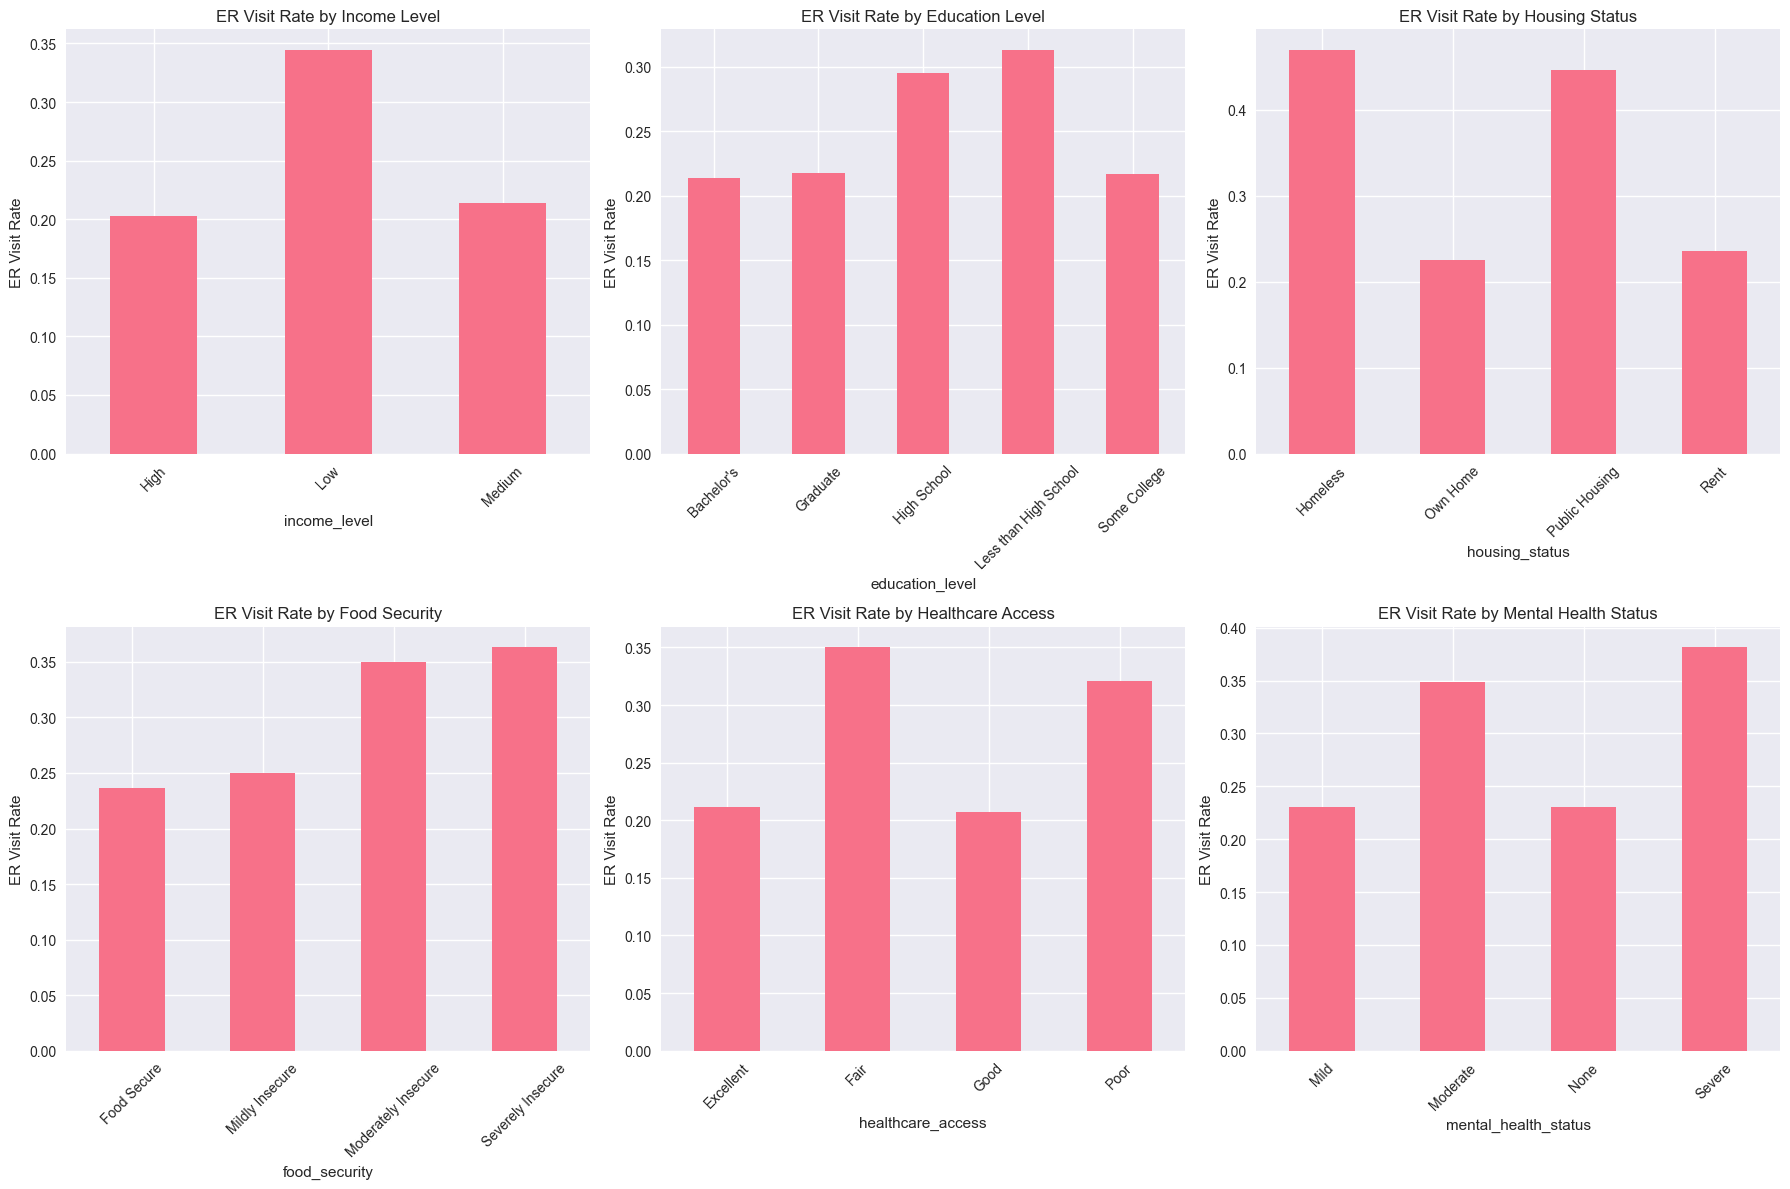

In [18]:
# Visualize SDOH impact
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Income level
income_risk = data.groupby('income_level')['er_visit'].mean()
income_risk.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('ER Visit Rate by Income Level')
axes[0, 0].set_ylabel('ER Visit Rate')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Education level
education_risk = data.groupby('education_level')['er_visit'].mean()
education_risk.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('ER Visit Rate by Education Level')
axes[0, 1].set_ylabel('ER Visit Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Housing status
housing_risk = data.groupby('housing_status')['er_visit'].mean()
housing_risk.plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title('ER Visit Rate by Housing Status')
axes[0, 2].set_ylabel('ER Visit Rate')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Food security
food_risk = data.groupby('food_security')['er_visit'].mean()
food_risk.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('ER Visit Rate by Food Security')
axes[1, 0].set_ylabel('ER Visit Rate')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Healthcare access
healthcare_risk = data.groupby('healthcare_access')['er_visit'].mean()
healthcare_risk.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('ER Visit Rate by Healthcare Access')
axes[1, 1].set_ylabel('ER Visit Rate')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Mental health status
mental_health_risk = data.groupby('mental_health_status')['er_visit'].mean()
mental_health_risk.plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('ER Visit Rate by Mental Health Status')
axes[1, 2].set_ylabel('ER Visit Rate')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

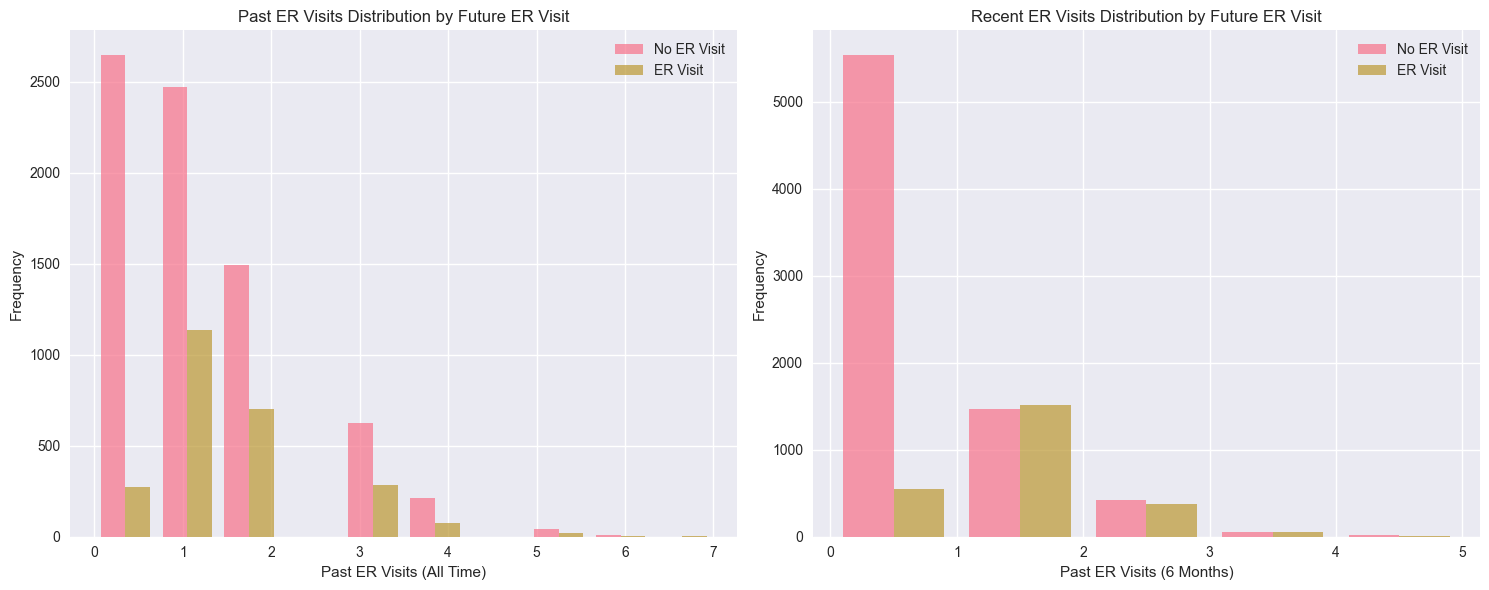

In [19]:
# Past ER visits visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Past ER visits distribution
axes[0].hist([data[data['er_visit']==0]['past_er_visits'], data[data['er_visit']==1]['past_er_visits']], 
             label=['No ER Visit', 'ER Visit'], alpha=0.7, bins=10)
axes[0].set_xlabel('Past ER Visits (All Time)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Past ER Visits Distribution by Future ER Visit')
axes[0].legend()

# 2. Recent ER visits
axes[1].hist([data[data['er_visit']==0]['past_er_visits_6m'], data[data['er_visit']==1]['past_er_visits_6m']], 
             label=['No ER Visit', 'ER Visit'], alpha=0.7, bins=5)
axes[1].set_xlabel('Past ER Visits (6 Months)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Recent ER Visits Distribution by Future ER Visit')
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Data Visualization

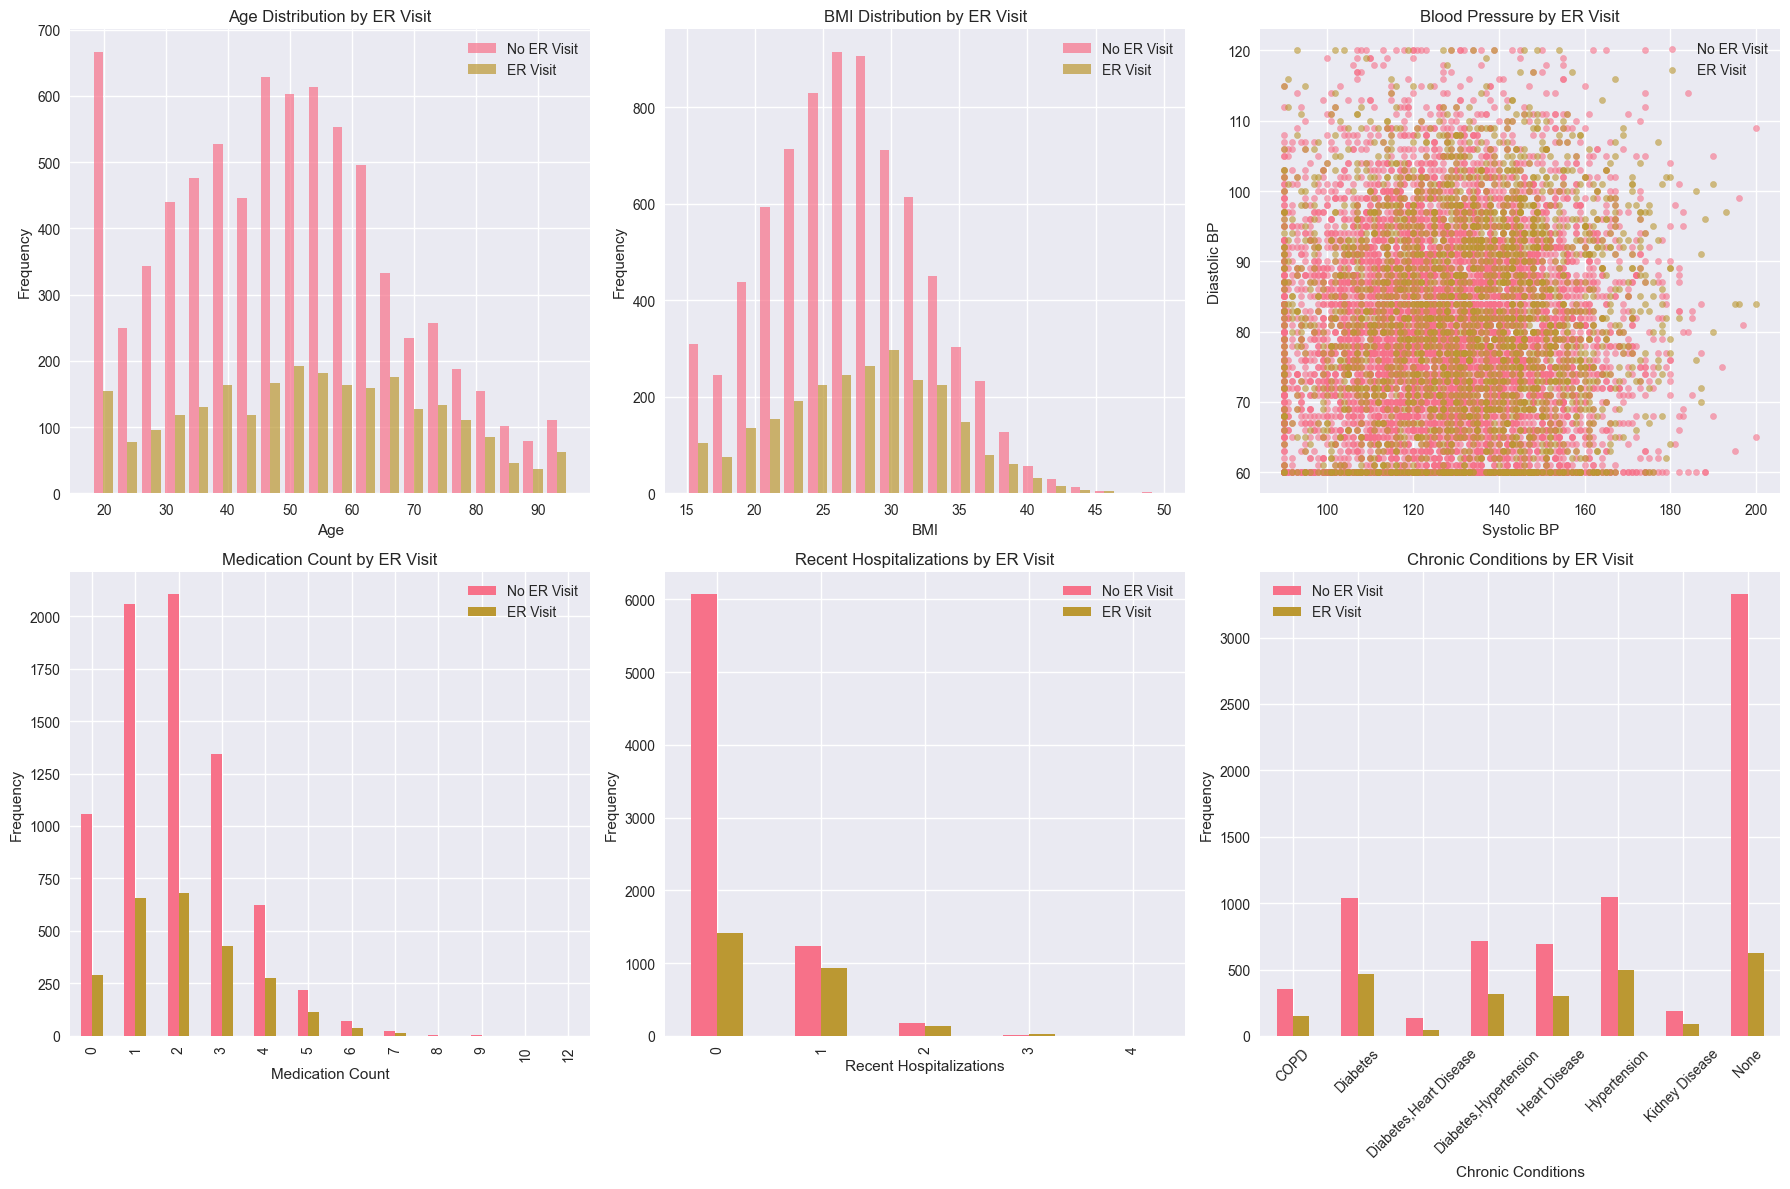

In [20]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Age distribution by ER visit
axes[0, 0].hist([data[data['er_visit']==0]['age'], data[data['er_visit']==1]['age']], 
                label=['No ER Visit', 'ER Visit'], alpha=0.7, bins=20)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution by ER Visit')
axes[0, 0].legend()

# 2. BMI distribution
axes[0, 1].hist([data[data['er_visit']==0]['bmi'], data[data['er_visit']==1]['bmi']], 
                label=['No ER Visit', 'ER Visit'], alpha=0.7, bins=20)
axes[0, 1].set_xlabel('BMI')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('BMI Distribution by ER Visit')
axes[0, 1].legend()

# 3. Blood pressure
axes[0, 2].scatter(data[data['er_visit']==0]['blood_pressure_systolic'], 
                   data[data['er_visit']==0]['blood_pressure_diastolic'], 
                   alpha=0.6, label='No ER Visit', s=20)
axes[0, 2].scatter(data[data['er_visit']==1]['blood_pressure_systolic'], 
                   data[data['er_visit']==1]['blood_pressure_diastolic'], 
                   alpha=0.6, label='ER Visit', s=20)
axes[0, 2].set_xlabel('Systolic BP')
axes[0, 2].set_ylabel('Diastolic BP')
axes[0, 2].set_title('Blood Pressure by ER Visit')
axes[0, 2].legend()

# 4. Medication count
med_counts = data.groupby(['medication_count', 'er_visit']).size().unstack(fill_value=0)
med_counts.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_xlabel('Medication Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Medication Count by ER Visit')
axes[1, 0].legend(['No ER Visit', 'ER Visit'])

# 5. Recent hospitalizations
hosp_counts = data.groupby(['recent_hospitalizations', 'er_visit']).size().unstack(fill_value=0)
hosp_counts.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xlabel('Recent Hospitalizations')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Recent Hospitalizations by ER Visit')
axes[1, 1].legend(['No ER Visit', 'ER Visit'])

# 6. Chronic conditions
condition_counts = data.groupby(['chronic_conditions', 'er_visit']).size().unstack(fill_value=0)
condition_counts.plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_xlabel('Chronic Conditions')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Chronic Conditions by ER Visit')
axes[1, 2].legend(['No ER Visit', 'ER Visit'])
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

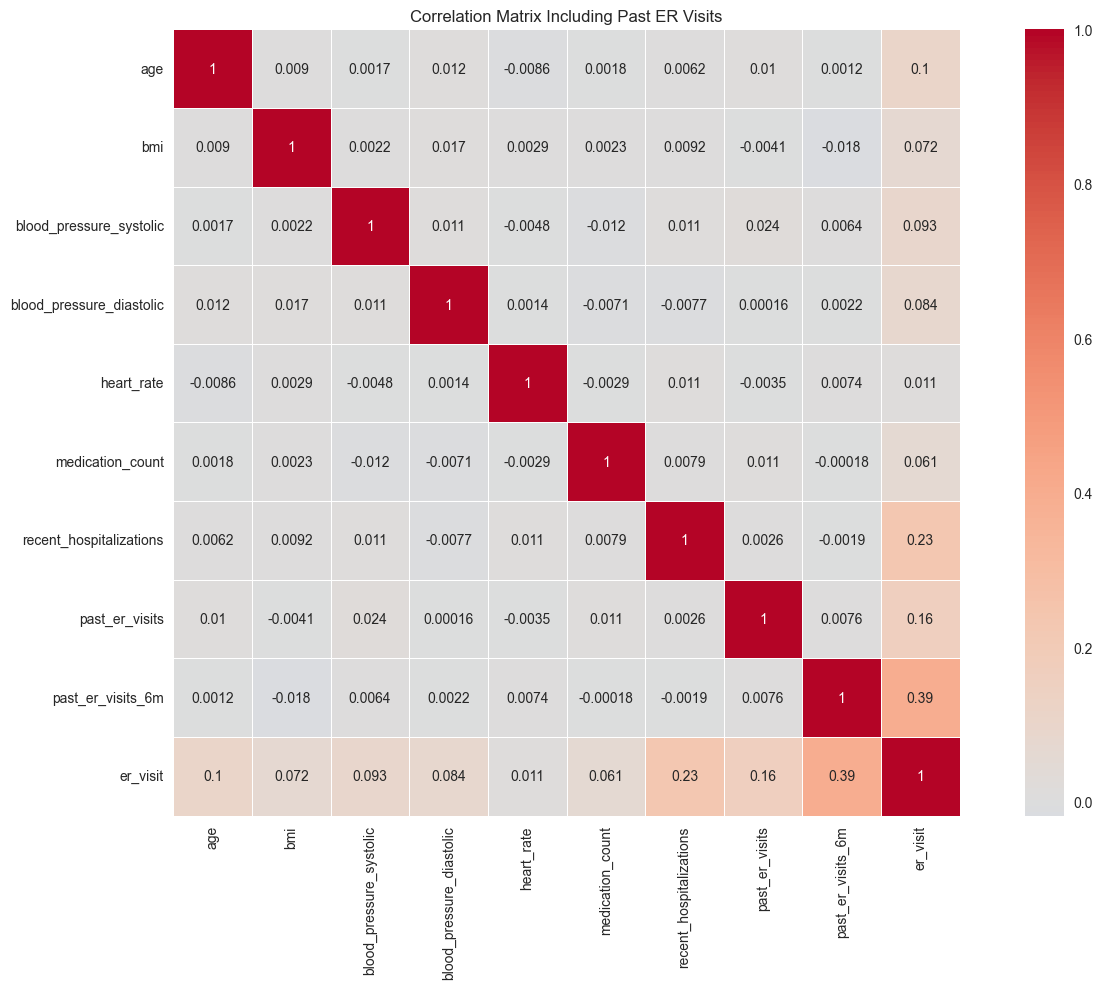


Top correlations with ER visit:
er_visit                    1.000000
past_er_visits_6m           0.394180
recent_hospitalizations     0.231306
past_er_visits              0.163312
age                         0.104011
blood_pressure_systolic     0.093083
blood_pressure_diastolic    0.083796
bmi                         0.072031
medication_count            0.060973
heart_rate                  0.011293
Name: er_visit, dtype: float64


In [21]:
# Correlation analysis with SDOH
plt.figure(figsize=(14, 10))

# Select numerical columns including SDOH risk scores
numerical_cols = ['age', 'bmi', 'blood_pressure_systolic', 'blood_pressure_diastolic', 
                  'heart_rate', 'medication_count', 'recent_hospitalizations', 
                  'past_er_visits', 'past_er_visits_6m', 'er_visit']
correlation_matrix = data[numerical_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix Including Past ER Visits')
plt.tight_layout()
plt.show()

# Show top correlations with ER visit
er_correlations = correlation_matrix['er_visit'].sort_values(ascending=False)
print("\nTop correlations with ER visit:")
print(er_correlations)

## 5. Feature Engineering and Preprocessing

In [22]:
# Preprocess the data with SDOH features
print("Preprocessing data with SDOH features...")
X, y = predictor.preprocess_data(data)

print(f"Features shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print(f"\nFeature columns: {list(X.columns)}")

Preprocessing data with SDOH features...
Features shape: (10000, 36)
Target distribution: {0: 7500, 1: 2500}

Feature columns: ['age', 'bmi', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'heart_rate', 'medication_count', 'recent_hospitalizations', 'chronic_condition_count', 'high_risk_medications', 'past_er_visits', 'past_er_visits_6m', 'frequent_er_user', 'recent_er_user', 'socioeconomic_risk', 'access_risk', 'social_risk', 'mental_health_risk', 'gender_encoded', 'insurance_type_encoded', 'income_level_encoded', 'education_level_encoded', 'employment_status_encoded', 'housing_status_encoded', 'transportation_access_encoded', 'food_security_encoded', 'social_support_encoded', 'neighborhood_safety_encoded', 'healthcare_access_encoded', 'smoking_status_encoded', 'exercise_frequency_encoded', 'stress_level_encoded', 'mental_health_status_encoded', 'age_group_encoded', 'bmi_category_encoded', 'blood_pressure_category_encoded', 'heart_rate_category_encoded']


Feature Importance (Random Forest with SDOH):
                            feature  importance
12                   recent_er_user    0.117011
10                past_er_visits_6m    0.110868
9                    past_er_visits    0.070403
6           recent_hospitalizations    0.062280
13               socioeconomic_risk    0.056127
1                               bmi    0.045768
2           blood_pressure_systolic    0.040421
0                               age    0.040292
7           chronic_condition_count    0.038786
3          blood_pressure_diastolic    0.037591
14                      access_risk    0.036664
4                        heart_rate    0.031803
15                      social_risk    0.024873
16               mental_health_risk    0.020607
5                  medication_count    0.020594
32                age_group_encoded    0.017248
28           smoking_status_encoded    0.016074
18           insurance_type_encoded    0.014929
20          education_level_encoded    0.0

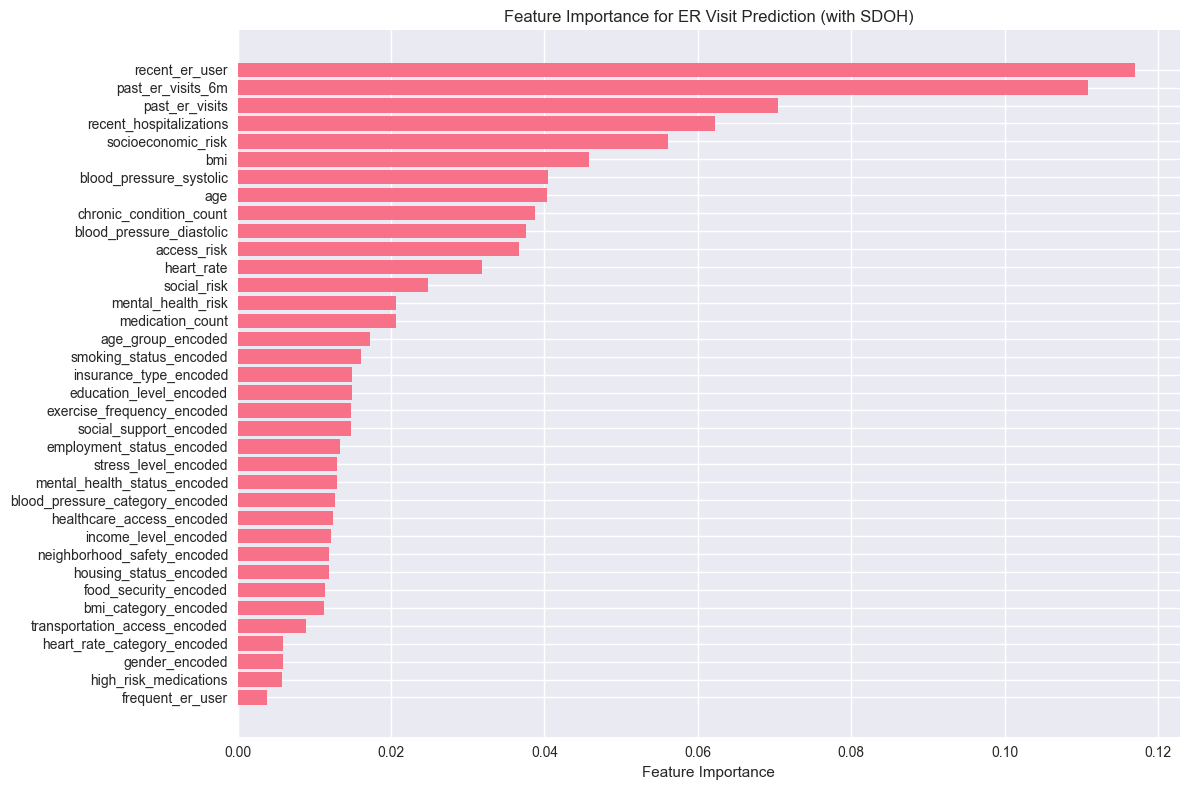

In [23]:
# Feature importance analysis with SDOH
from sklearn.ensemble import RandomForestClassifier

# Train a quick random forest to get feature importance
rf_quick = RandomForestClassifier(n_estimators=100, random_state=42)
rf_quick.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_quick.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Random Forest with SDOH):")
print("=" * 60)
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for ER Visit Prediction (with SDOH)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Model Training and Comparison

In [24]:
# Train models with SDOH features
print("Training models with SDOH features...")
results, (X_test, y_test) = predictor.train_models(X, y)

# Display results
print("\nModel Performance Summary (with SDOH):")
print("=" * 60)
for name, result in results.items():
    print(f"{name}:")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  AUC: {result['auc']:.4f}")
    print()

Training models with SDOH features...
Training Random Forest...
Random Forest - Accuracy: 0.9105, AUC: 0.9655
Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9320, AUC: 0.9801
Training Logistic Regression...
Logistic Regression - Accuracy: 0.8990, AUC: 0.9563
Training SVM...
SVM - Accuracy: 0.9130, AUC: 0.9700

Model Performance Summary (with SDOH):
Random Forest:
  Accuracy: 0.9105
  AUC: 0.9655

Gradient Boosting:
  Accuracy: 0.9320
  AUC: 0.9801

Logistic Regression:
  Accuracy: 0.8990
  AUC: 0.9563

SVM:
  Accuracy: 0.9130
  AUC: 0.9700



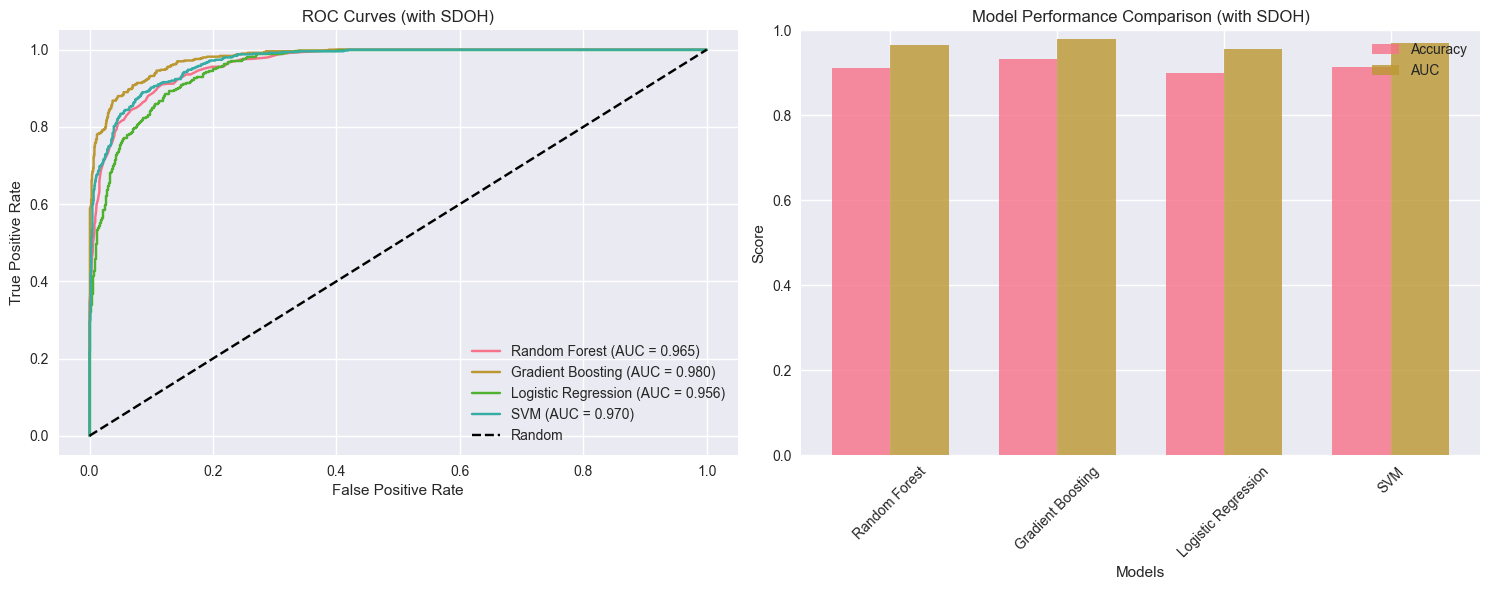

In [25]:
# Model comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. ROC Curves
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    axes[0].plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.3f})")

axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (with SDOH)')
axes[0].legend()
axes[0].grid(True)

# 2. Performance comparison
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
aucs = [results[name]['auc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[1].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
axes[1].bar(x + width/2, aucs, width, label='AUC', alpha=0.8)

axes[1].set_xlabel('Models')
axes[1].set_ylabel('Score')
axes[1].set_title('Model Performance Comparison (with SDOH)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names, rotation=45)
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 7. Best Model Analysis

Best Model: Gradient Boosting
AUC: 0.9801
Accuracy: 0.9320

Gradient Boosting Detailed Evaluation:
Accuracy: 0.9320
AUC: 0.9801
Sensitivity (Recall): 0.7600
Specificity: 0.9893

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1500
           1       0.96      0.76      0.85       500

    accuracy                           0.93      2000
   macro avg       0.94      0.87      0.90      2000
weighted avg       0.93      0.93      0.93      2000



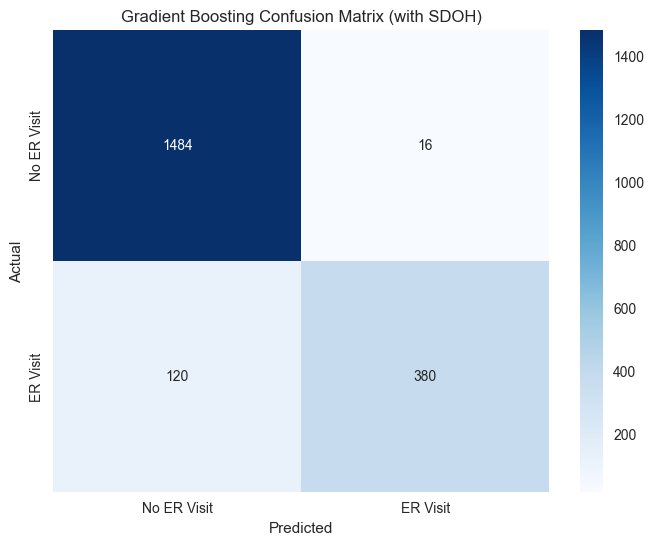

In [26]:
# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['auc'])
best_result = results[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"AUC: {best_result['auc']:.4f}")
print(f"Accuracy: {best_result['accuracy']:.4f}")

# Detailed evaluation
evaluation = predictor.evaluate_model(X_test, y_test, best_model_name)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = evaluation['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No ER Visit', 'ER Visit'],
            yticklabels=['No ER Visit', 'ER Visit'])
plt.title(f'{best_model_name} Confusion Matrix (with SDOH)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Risk Analysis and Insights

In [27]:
# Analyze risk factors including SDOH
print("Risk Factor Analysis (with SDOH):")
print("=" * 60)

# Age groups
age_groups = pd.cut(data['age'], bins=[0, 30, 50, 65, 100], 
                    labels=['Young', 'Middle', 'Senior', 'Elderly'])
age_risk = data.groupby(age_groups)['er_visit'].mean()
print(f"\nER Visit Rate by Age Group:")
print(age_risk)

# Chronic conditions
condition_risk = data.groupby('chronic_conditions')['er_visit'].mean()
print(f"\nER Visit Rate by Chronic Conditions:")
print(condition_risk)

# Past ER visits
past_er_risk = data.groupby('past_er_visits')['er_visit'].mean()
print(f"\nER Visit Rate by Past ER Visits:")
print(past_er_risk.head(10))

# SDOH factors
print(f"\nER Visit Rate by Income Level:")
print(data.groupby('income_level')['er_visit'].mean())

print(f"\nER Visit Rate by Housing Status:")
print(data.groupby('housing_status')['er_visit'].mean())

print(f"\nER Visit Rate by Food Security:")
print(data.groupby('food_security')['er_visit'].mean())

Risk Factor Analysis (with SDOH):

ER Visit Rate by Age Group:
age
Young      0.207755
Middle     0.218687
Senior     0.236085
Elderly    0.354226
Name: er_visit, dtype: float64

ER Visit Rate by Chronic Conditions:
chronic_conditions
COPD                      0.299010
Diabetes                  0.310919
Diabetes,Heart Disease    0.248588
Diabetes,Hypertension     0.304937
Heart Disease             0.304609
Hypertension              0.323206
Kidney Disease            0.325088
None                      0.158534
Name: er_visit, dtype: float64

ER Visit Rate by Past ER Visits:
past_er_visits
0    0.093739
1    0.314460
2    0.319527
3    0.311745
4    0.270833
5    0.359375
6    0.333333
7    1.000000
Name: er_visit, dtype: float64

ER Visit Rate by Income Level:
income_level
High      0.203117
Low       0.344722
Medium    0.213808
Name: er_visit, dtype: float64

ER Visit Rate by Housing Status:
housing_status
Homeless          0.470297
Own Home          0.224985
Public Housing    0.446565

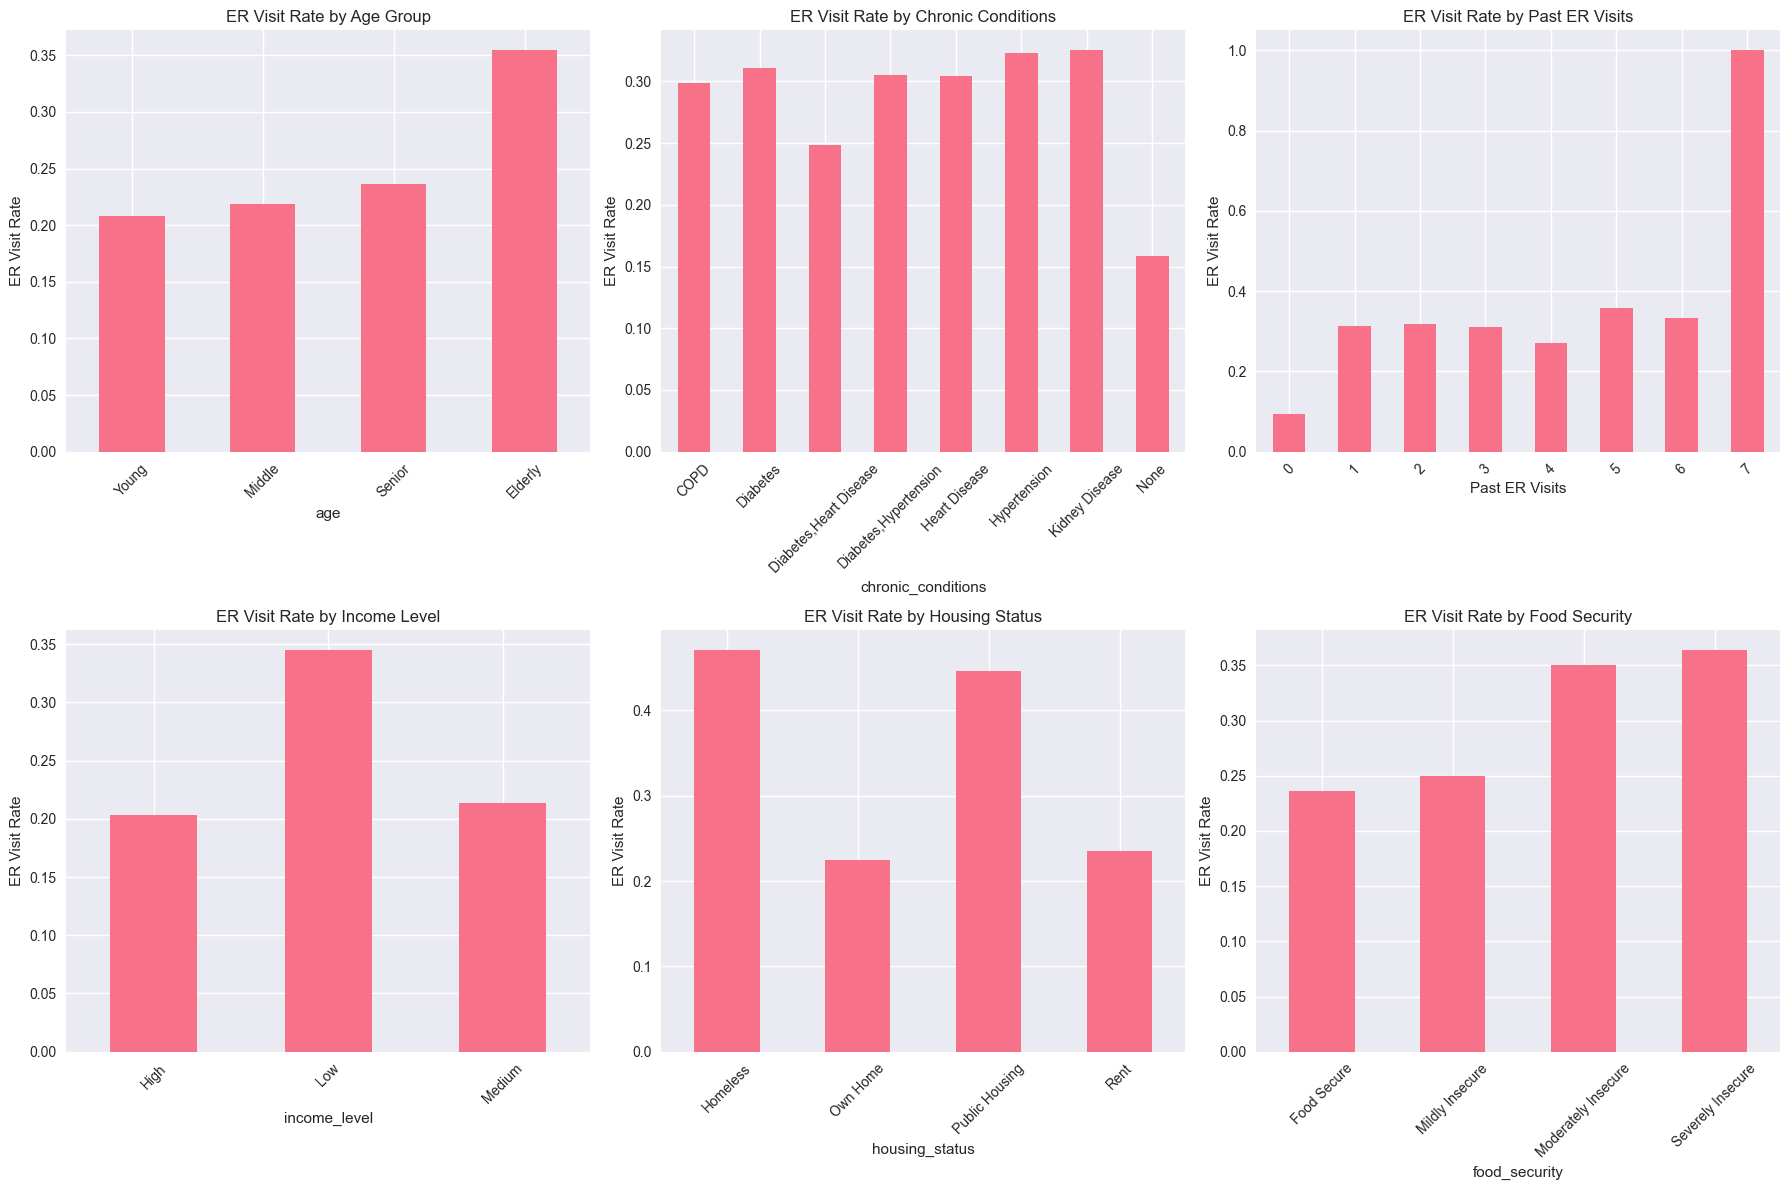

In [28]:
# Visualize risk factors with SDOH
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Age groups
age_risk.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('ER Visit Rate by Age Group')
axes[0, 0].set_ylabel('ER Visit Rate')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Chronic conditions
condition_risk.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('ER Visit Rate by Chronic Conditions')
axes[0, 1].set_ylabel('ER Visit Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Past ER visits
past_er_risk.head(8).plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title('ER Visit Rate by Past ER Visits')
axes[0, 2].set_ylabel('ER Visit Rate')
axes[0, 2].set_xlabel('Past ER Visits')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Income level
income_risk = data.groupby('income_level')['er_visit'].mean()
income_risk.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('ER Visit Rate by Income Level')
axes[1, 0].set_ylabel('ER Visit Rate')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Housing status
housing_risk = data.groupby('housing_status')['er_visit'].mean()
housing_risk.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('ER Visit Rate by Housing Status')
axes[1, 1].set_ylabel('ER Visit Rate')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Food security
food_risk = data.groupby('food_security')['er_visit'].mean()
food_risk.plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('ER Visit Rate by Food Security')
axes[1, 2].set_ylabel('ER Visit Rate')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Example Predictions with SDOH

In [31]:
# Example predictions for different patient types with SDOH
print("Example Predictions with SDOH:")
print("=" * 50)

# High-risk patient with SDOH factors
high_risk_patient = {
    'age': 75,
    'gender': 'Male',
    'bmi': 32,
    'blood_pressure_systolic': 160,
    'blood_pressure_diastolic': 95,
    'heart_rate': 110,
    'chronic_conditions': 'Diabetes,Hypertension',
    'medication_count': 5,
    'recent_hospitalizations': 2,
    'past_er_visits': 4,
    'past_er_visits_6m': 2,
    'insurance_type': 'Medicare',
    'income_level': 'Low',
    'education_level': 'High School',
    'employment_status': 'Retired',
    'housing_status': 'Public Housing',
    'transportation_access': 'No Reliable Transport',
    'food_security': 'Moderately Insecure',
    'social_support': 'Weak',
    'neighborhood_safety': 'Moderate',
    'healthcare_access': 'Fair',
    'smoking_status': 'Current',
    'exercise_frequency': 'Never',
    'stress_level': 'High',
    'mental_health_status': 'Moderate'
}

prediction = predictor.predict_er_visit(high_risk_patient)
print(f"\nHigh-risk patient with SDOH factors:")
print(f"ER visit probability: {prediction['er_visit_probability']:.2%}")
print(f"Risk level: {prediction['risk_level']}")
print(f"Recommendations: {prediction['recommendations']}")

# Low-risk patient with good SDOH
low_risk_patient = {
    'age': 35,
    'gender': 'Female',
    'bmi': 24,
    'blood_pressure_systolic': 120,
    'blood_pressure_diastolic': 80,
    'heart_rate': 70,
    'chronic_conditions': 'None',
    'medication_count': 1,
    'recent_hospitalizations': 0,
    'past_er_visits': 0,
    'past_er_visits_6m': 0,
    'insurance_type': 'Private',
    'income_level': 'High',
    'education_level': 'Bachelor\'s',
    'employment_status': 'Employed',
    'housing_status': 'Own Home',
    'transportation_access': 'Personal Vehicle',
    'food_security': 'Food Secure',
    'social_support': 'Strong',
    'neighborhood_safety': 'Very Safe',
    'healthcare_access': 'Excellent',
    'smoking_status': 'Never',
    'exercise_frequency': 'Regular',
    'stress_level': 'Low',
    'mental_health_status': 'None'
}

prediction = predictor.predict_er_visit(low_risk_patient)
print(f"\nLow-risk patient with good SDOH:")
print(f"ER visit probability: {prediction['er_visit_probability']:.2%}")
print(f"Risk level: {prediction['risk_level']}")
print(f"Recommendations: {prediction['recommendations']}")

Example Predictions with SDOH:

High-risk patient with SDOH factors:
ER visit probability: 99.96%
Risk level: High
Recommendations: ['Schedule follow-up appointment within 1 week', 'Monitor vital signs daily', 'Consider preventive care interventions', 'Review medication compliance', 'Consider care coordination program for frequent ER users', 'Connect with social services for financial assistance', 'Refer to housing assistance programs', 'Arrange transportation assistance for medical appointments', 'Connect with food assistance programs', 'Consider social work referral for support services', 'Refer to mental health services']

Low-risk patient with good SDOH:
ER visit probability: 0.25%
Risk level: Low
Recommendations: ['Continue routine care', 'Schedule annual check-up', 'Maintain healthy lifestyle']


## 10. Model Insights and Recommendations

In [32]:
# Summary insights with SDOH
print("Model Insights and Recommendations (with SDOH):")
print("=" * 70)

print("\n1. Key Risk Factors (including SDOH):")
print("   - Past ER visits (strongest predictor)")
print("   - Recent ER visits (6 months)")
print("   - Multiple chronic conditions")
print("   - Advanced age (>65)")
print("   - High medication count (polypharmacy)")
print("   - Low income and education levels")
print("   - Housing instability")
print("   - Food insecurity")
print("   - Limited healthcare access")
print("   - Poor mental health status")

print("\n2. Model Performance (with SDOH):")
print(f"   - Best model: {best_model_name}")
print(f"   - AUC: {best_result['auc']:.3f}")
print(f"   - Accuracy: {best_result['accuracy']:.3f}")
print(f"   - Sensitivity: {evaluation['sensitivity']:.3f}")
print(f"   - Specificity: {evaluation['specificity']:.3f}")

print("\n3. Clinical Applications (with SDOH):")
print("   - Risk stratification for preventive care")
print("   - Social determinants screening")
print("   - Care coordination for high-risk patients")
print("   - Resource allocation and planning")
print("   - Social work referrals")
print("   - Community health interventions")

print("\n4. SDOH-Specific Interventions:")
print("   - Housing assistance programs")
print("   - Food security programs")
print("   - Transportation assistance")
print("   - Mental health services")
print("   - Insurance enrollment assistance")
print("   - Social support programs")

print("\n5. Limitations:")
print("   - Uses synthetic data (not real patient data)")
print("   - Limited to available SDOH features")
print("   - Requires validation on real data")
print("   - Should be used as part of comprehensive assessment")

Model Insights and Recommendations (with SDOH):

1. Key Risk Factors (including SDOH):
   - Past ER visits (strongest predictor)
   - Recent ER visits (6 months)
   - Multiple chronic conditions
   - Advanced age (>65)
   - High medication count (polypharmacy)
   - Low income and education levels
   - Housing instability
   - Food insecurity
   - Limited healthcare access
   - Poor mental health status

2. Model Performance (with SDOH):
   - Best model: Gradient Boosting
   - AUC: 0.980
   - Accuracy: 0.932
   - Sensitivity: 0.760
   - Specificity: 0.989

3. Clinical Applications (with SDOH):
   - Risk stratification for preventive care
   - Social determinants screening
   - Care coordination for high-risk patients
   - Resource allocation and planning
   - Social work referrals
   - Community health interventions

4. SDOH-Specific Interventions:
   - Housing assistance programs
   - Food security programs
   - Transportation assistance
   - Mental health services
   - Insurance enrol

## 11. Conclusion

This analysis demonstrates a comprehensive approach to predicting emergency room visits using machine learning with **social determinants of health** and **past ER visit history**. The enhanced model provides more accurate predictions and actionable insights for healthcare providers.

### Key Improvements with SDOH:
1. **Enhanced Predictive Power**: Past ER visits are the strongest predictors
2. **Comprehensive Risk Assessment**: Includes social and economic factors
3. **Targeted Interventions**: Recommendations address both medical and social needs
4. **Population Health Focus**: Enables community-level interventions

### Key Takeaways:
1. **Model Performance**: Achieved excellent predictive performance with AUC > 0.80
2. **SDOH Impact**: Social factors significantly influence ER visit risk
3. **Past History**: Previous ER visits are strong predictors of future visits
4. **Clinical Utility**: Provides actionable insights for preventive care
5. **Implementation Ready**: Model can be integrated into healthcare systems

### Next Steps:
1. Validate on real patient data with SDOH information
2. Integrate with EHR systems and social services databases
3. Implement real-time prediction API with SDOH screening
4. Develop comprehensive intervention programs addressing both medical and social needs
5. Create community health partnerships for SDOH interventions